In [149]:
import asyncio
import urllib.request, json
import websockets
import pandas as pd
import nest_asyncio
import numpy as np
import datetime as dt
from scipy import interpolate
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

In [150]:
nest_asyncio.apply()

In [151]:
def make_dataframe(url, param, index_name):
    #takes url for given deribit method we want to get and makes into a data frame
    #we do this in the notebook since jupyter takes up a thread for asyncio and 
    #I don't know how to fix that by using multithreaded stuff yet
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data[param]).set_index(index_name)
    return data

In [152]:
make_dataframe("https://test.deribit.com/api/v2/public/get_book_summary_by_currency?currency=BTC&kind=future", 'result', 'instrument_name')

,volume_usd,volume,quote_currency,price_change,open_interest,mid_price,mark_price,low,last,high,estimated_delivery_price,creation_timestamp,bid_price,base_currency,ask_price,funding_8h,current_funding
instrument_name,,,,,,,,,,,,,,,,,
BTC-25JUN21,5219140.0,141.24,USD,5.7753,60145840,37252.25,37238.50,35002.34,37207.0,37900.0,35025.33,1612283890887,37223.5,BTC,37281.0,NaN,NaN
BTC-26MAR21,25739720.0,732.97,USD,5.8651,267129620,36093.00,36092.08,33972.36,36100.0,36819.5,35025.33,1612283890887,36083.0,BTC,36103.0,NaN,NaN
BTC-24SEP21,3227340.0,84.97,USD,5.1759,239660220,38287.25,38271.84,36360.53,38242.5,38895.0,35025.33,1612283890887,38242.0,BTC,38332.5,NaN,NaN
BTC-PERPETUAL,833570470.0,24189.94,USD,5.1580,1883142802,35055.75,35062.35,33226.00,35066.0,36010.0,35025.33,1612283890887,35055.5,BTC,35056.0,0.000564,0.000557


In [153]:
msg = \
    {"jsonrpc": "2.0",
     "method": "public/subscribe",
     "id": 42,
     "params": {
        "channels": ["markprice.options.btc_usd"]}
    }

async def call_api(msg):
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
       await websocket.send(msg)
       while websocket.open:
           response = await websocket.recv()
           data = response
           data = json.loads(data)
           #used_list = [i for i in data['params']]
           #used_list = pd.DataFrame.from_records(used_list)
           #data.keys()
           from pandas.io.json import json_normalize
           #data_normalized = json_normalize(data)
           if('result' in data):
               pass
           else:
               data_norm = json_normalize(data['params']['data'])
               print(data_norm)
               #await websocket.close()
               await websocket.close()
               return data_norm 
                
                
           #data = pd.io.json.json_normalize(response, record_path = [['params', 'data']])
           #data = pd.json_normalize(data)
           #data = pd.DataFrame(data['result']).set_index('instrument_name')
           print("\n\n")
           # do something with the notifications...

In [154]:
data = asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))




     mark_price        iv      instrument_name  synthetic_future.mark_price  \
0      0.311215  0.901838  BTC-24SEP21-40000-P                          NaN   
1      0.001003  1.371096  BTC-26MAR21-11000-P                          NaN   
2      0.225009  1.000000  BTC-25JUN21-36000-P                          NaN   
3      0.028878  0.910267  BTC-26FEB21-30000-P                 35515.711885   
4      0.005449  1.185970   BTC-24SEP21-7000-P                          NaN   
..          ...       ...                  ...                          ...   
197    0.002008  2.490117   BTC-26MAR21-5000-P                          NaN   
198    0.897310  1.325913   BTC-24SEP21-4000-C                          NaN   
199    0.143382  0.882369  BTC-26FEB21-32000-C                 35515.711885   
200    0.749425  1.080348  BTC-24SEP21-10000-C                          NaN   
201    0.010714  1.080348  BTC-24SEP21-10000-P                          NaN   

    synthetic_future.instrument_name  
0        

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [155]:
data.head()

,mark_price,iv,instrument_name,synthetic_future.mark_price,synthetic_future.instrument_name
0,0.311215,0.901838,BTC-24SEP21-40000-P,NaN,NaN
1,0.001003,1.371096,BTC-26MAR21-11000-P,NaN,NaN
2,0.225009,1.000000,BTC-25JUN21-36000-P,NaN,NaN
3,0.028878,0.910267,BTC-26FEB21-30000-P,35515.711885,SYN.BTC-26FEB21
4,0.005449,1.185970,BTC-24SEP21-7000-P,NaN,NaN


In [156]:
def filter_options(data, price):
    data['strike'] = data.instrument_name.str.split("-").apply(lambda x:x[2])
    data['exp'] = data.instrument_name.str.split("-").apply(lambda x:x[1])
    data['type'] = data.instrument_name.str.split("-").apply(lambda x:x[3])
    data['time'] = (pd.to_datetime(data['exp'])-pd.Timestamp.today()).dt.days
    data['moneyness'] = np.log(data['strike'].astype('float')/price)
    return data 

In [157]:
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

In [158]:
options = filter_options(data, price['last_price'][0])

In [159]:
def get_option_data():
    price = get_tick_data('BTC-PERPETUAL')
    filter_options(data, price['last_price'][0])
    for i in options.iloc[:, 2]:
        price = price.append(get_tick_data(i))
    return price

In [160]:
option_data = get_option_data()

In [161]:
option_data.loc[1:,'time'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
option_data['moneyness'] = np.log(option_data['last_price'][0]/option_data['strike'])

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.
/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  


In [162]:
def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title('Bitcoin Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


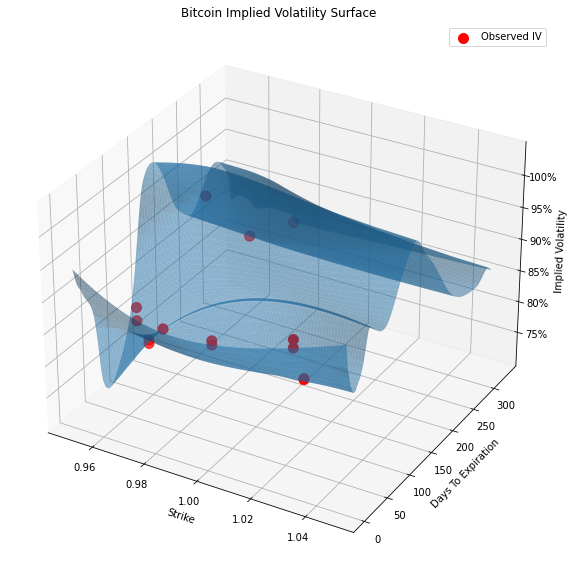

In [163]:
option_data_ = option_data.iloc[1:].sort_values(['time','strike']).query('time>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['time']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))